In [1]:
import os
import time
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 100

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

shap.initjs()

In [2]:
X,y = shap.datasets.adult()
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

# create a train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.7, random_state=7)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=7)
del X, y

In [3]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.01
num_epochs = 100
training_batch_size = 64
eval_batch_size = max(X_valid.shape[0], X_valid.shape[0])
dropout_prob = 0.2

# Architecture
num_features = X_train.shape[1]
num_hidden_1 = 20
num_hidden_2 = 20
num_hidden_3 = 10
num_classes = 2

train_tensor = torch.from_numpy(X_train.values)
y_tensor = torch.from_numpy(y_train.astype('float'))
train_dataset = TensorDataset(train_tensor, y_tensor)

valid_tensor = torch.from_numpy(X_valid.values)
y_tensor = torch.from_numpy(y_valid.astype('float'))
valid_dataset = TensorDataset(valid_tensor, y_tensor)

test_tensor = torch.from_numpy(X_test.values)
y_tensor = torch.from_numpy(y_test.astype('float'))
test_dataset = TensorDataset(test_tensor, y_tensor)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=training_batch_size, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=eval_batch_size, 
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=eval_batch_size, 
                          shuffle=False)

# Checking the dataset
for data, labels in train_loader:  
    print('training batch dimensions:', data.shape)
    print('training label dimensions:', labels.shape)
    break

training batch dimensions: torch.Size([64, 12])
training label dimensions: torch.Size([64])


In [4]:
##########################
### MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        
        ### 3th hidden layer
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)

        
    def forward(self, x):
        out = self.linear_1(x.float())
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        out = self.linear_2(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        out = self.linear_3(out)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_prob, training=self.training)
        
        logits = self.linear_out(out)
        return logits

    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
from sklearn.metrics import roc_auc_score

def compute_auc(net, data_loader):
    net.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            logits = net(features)
            y_pred = np.hstack([y_pred, logits[:, 1]])
            y_true = np.hstack([y_true, targets])
        return roc_auc_score(y_true, y_pred)


start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = F.cross_entropy(logits, targets.long())
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()


    print('Epoch: %03d/%03d training auc: %.4f | valid auc: %.4f | test auc: %.4f | time: %.2f min' % (
          epoch+1, num_epochs, 
          compute_auc(model, train_loader),
          compute_auc(model, valid_loader),
          compute_auc(model, test_loader),
          (time.time() - start_time)/60)
    )

Epoch: 001/100 training auc: 0.5599 | valid auc: 0.5468 | test auc: 0.5450 | time: 0.01 min
Epoch: 002/100 training auc: 0.6495 | valid auc: 0.6393 | test auc: 0.6353 | time: 0.01 min
Epoch: 003/100 training auc: 0.7219 | valid auc: 0.7131 | test auc: 0.7089 | time: 0.02 min
Epoch: 004/100 training auc: 0.7696 | valid auc: 0.7614 | test auc: 0.7572 | time: 0.03 min
Epoch: 005/100 training auc: 0.8016 | valid auc: 0.7943 | test auc: 0.7895 | time: 0.04 min
Epoch: 006/100 training auc: 0.8242 | valid auc: 0.8180 | test auc: 0.8129 | time: 0.04 min
Epoch: 007/100 training auc: 0.8394 | valid auc: 0.8344 | test auc: 0.8289 | time: 0.05 min
Epoch: 008/100 training auc: 0.8509 | valid auc: 0.8470 | test auc: 0.8412 | time: 0.06 min
Epoch: 009/100 training auc: 0.8591 | valid auc: 0.8562 | test auc: 0.8501 | time: 0.06 min
Epoch: 010/100 training auc: 0.8652 | valid auc: 0.8628 | test auc: 0.8566 | time: 0.07 min
Epoch: 011/100 training auc: 0.8695 | valid auc: 0.8675 | test auc: 0.8609 | tim

Epoch: 091/100 training auc: 0.9044 | valid auc: 0.9032 | test auc: 0.8960 | time: 0.67 min
Epoch: 092/100 training auc: 0.9045 | valid auc: 0.9032 | test auc: 0.8960 | time: 0.68 min
Epoch: 093/100 training auc: 0.9045 | valid auc: 0.9033 | test auc: 0.8960 | time: 0.68 min
Epoch: 094/100 training auc: 0.9046 | valid auc: 0.9033 | test auc: 0.8960 | time: 0.69 min
Epoch: 095/100 training auc: 0.9047 | valid auc: 0.9033 | test auc: 0.8961 | time: 0.70 min
Epoch: 096/100 training auc: 0.9047 | valid auc: 0.9033 | test auc: 0.8962 | time: 0.71 min
Epoch: 097/100 training auc: 0.9048 | valid auc: 0.9034 | test auc: 0.8963 | time: 0.72 min
Epoch: 098/100 training auc: 0.9050 | valid auc: 0.9033 | test auc: 0.8963 | time: 0.73 min
Epoch: 099/100 training auc: 0.9049 | valid auc: 0.9033 | test auc: 0.8961 | time: 0.74 min
Epoch: 100/100 training auc: 0.9050 | valid auc: 0.9033 | test auc: 0.8961 | time: 0.74 min


In [6]:
%%time
batch = next(iter(test_loader))
data, _ = batch

background = data[:1000]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(data)[1]

CPU times: user 49min 41s, sys: 17.5 s, total: 49min 59s
Wall time: 13min 48s


In [7]:
shap.force_plot(explainer.expected_value[1], shap_values[0,:], X_test.iloc[0,:])

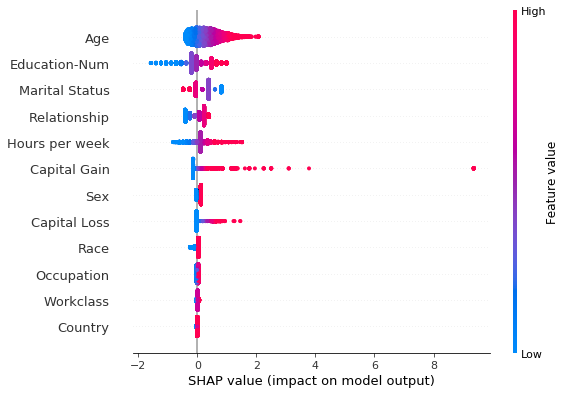

CPU times: user 2.71 s, sys: 716 ms, total: 3.42 s
Wall time: 1.98 s


In [8]:
%%time
shap.summary_plot(shap_values, X_test)

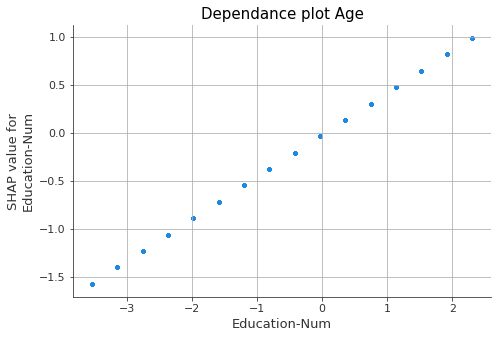

In [14]:
shap.dependence_plot("Education-Num", shap_values, X_test, interaction_index=None, show=False)
plt.title('Dependance plot Age', fontsize=15)
plt.grid()

In [27]:
%%time
batch = next(iter(test_loader))
data, _ = batch

background = data[:1000]
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(data)[1]

CPU times: user 7min 35s, sys: 2.75 s, total: 7min 38s
Wall time: 7min 39s


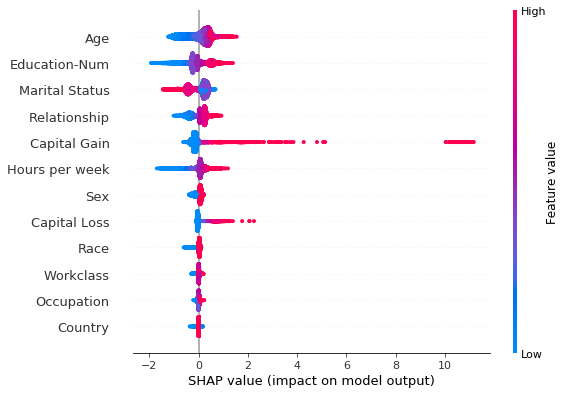

CPU times: user 2.56 s, sys: 717 ms, total: 3.27 s
Wall time: 1.81 s


In [32]:
%%time
shap.summary_plot(shap_values, X_test)

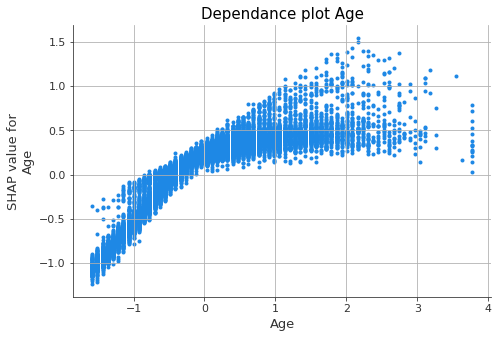

In [44]:
shap.dependence_plot("Age", shap_values, X_test, interaction_index=None, show=False)
plt.title('Dependance plot Age', fontsize=15)
plt.grid()